## Training an MLIP and its LLPR module

Now, we will walk you through a process where you train an MLIP, then also the LLPR module associated with it for uncertainty quantification. Let's first generate the set of structures and obtain the reference energies:

In [7]:
import ase.build
import ase.io
import matplotlib.pyplot as plt
import numpy as np

from ase.calculators.emt import EMT

calculator = EMT()
structure = ase.build.bulk("Al", "fcc", cubic=True)

We generate 1000 structures and compute the energies using the effective medium potential (EMT):

In [8]:
structures = []
for i in range(1000):
    s = structure.copy()
    s.rattle(0.3, seed=i)
    s.calc = calculator
    s.info["energy"] = s.get_potential_energy()
    s.arrays["forces"] = s.get_forces()
    s.info["stress"] = s.get_stress(voigt=False)
    s.calc = None
    structures.append(s)

Let's save the training and evaluation datasets:

In [9]:
ase.io.write("dataset.xyz", structures[:50])
ase.io.write("evaluation.xyz", structures[50:])

You can now launch the model training processes from the `metatrain` CLI. We first train the actual MLIP, then also "train" the LLPR module right after (run the following commands from your terminal in succession):

```
mtt train options.yaml
mtt train options-llpr.yaml -o model-llpr.pt
```



After the model training finishes, you can evaluate the model on the held out dataset:
```
mtt eval model-llpr.pt eval.yaml -b 20
```

Let's now plot the spread of actual errors vs. the predicted errors from the LLPR formalism:

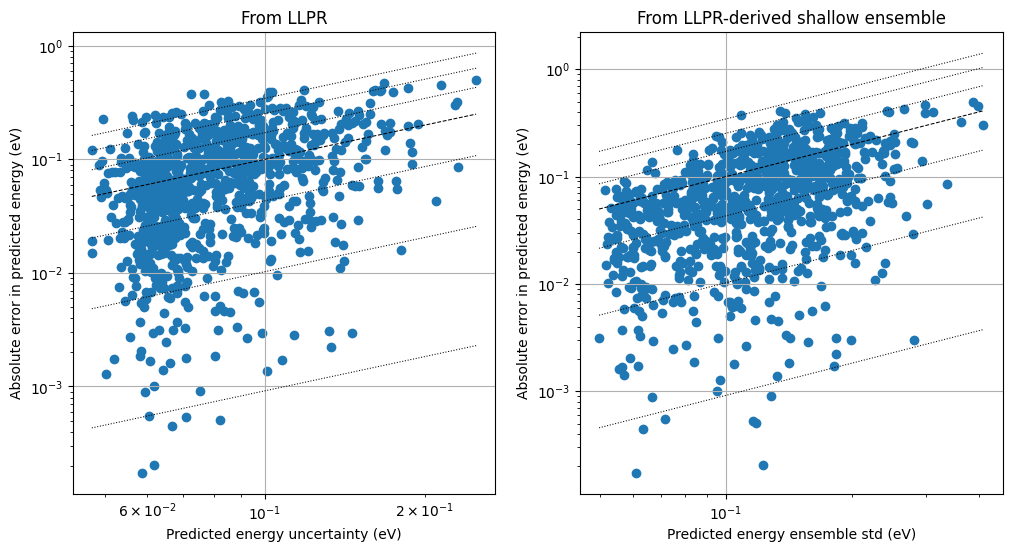

In [11]:

# Load the structures
structures = ase.io.read("evaluation.xyz", ":")
evaluated_structures = ase.io.read("output.xyz", ":")

# Obtain the predictions and uncertainties from the evaluated structures
predicted_energies = [s.get_potential_energy() for s in evaluated_structures]
true_energies = [s.get_potential_energy() for s in structures]
errors = np.abs(np.array(predicted_energies) - np.array(true_energies))
uncertainties = [s.info["energy_uncertainty"] for s in evaluated_structures]
ensemble_uncertainties = [s.info["energy_ensemble"].std() for s in evaluated_structures]

quantile_lines = [0.00916, 0.10256, 0.4309805, 1.71796, 2.5348, 3.44388]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot using normal uncertainties
min_val_x, max_val_x = np.min(uncertainties), np.max(uncertainties)
min_val_y, max_val_y = np.min(errors), np.max(errors)
ax[0].plot([min_val_x, max_val_x], [min_val_x, max_val_x], "k--", lw=0.75)
for factor in quantile_lines:
    ax[0].plot([min_val_x, max_val_x], [factor * min_val_x, factor * max_val_x], "k:", lw=0.75)
ax[0].scatter(uncertainties, errors)
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("Predicted energy uncertainty (eV)")
ax[0].set_ylabel("Absolute error in predicted energy (eV)")
ax[0].set_title("From LLPR")
ax[0].grid()

# Plot using ensemble uncertainties
min_val_x, max_val_x = np.min(ensemble_uncertainties), np.max(ensemble_uncertainties)
min_val_y, max_val_y = np.min(errors), np.max(errors)
ax[1].plot([min_val_x, max_val_x], [min_val_x, max_val_x], "k--", lw=0.75)
for factor in quantile_lines:
    ax[1].plot([min_val_x, max_val_x], [factor * min_val_x, factor * max_val_x], "k:", lw=0.75)
ax[1].scatter(ensemble_uncertainties, errors)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("Predicted energy ensemble std (eV)")
ax[1].set_ylabel("Absolute error in predicted energy (eV)")
ax[1].set_title("From LLPR-derived shallow ensemble")
ax[1].grid()
